# PCA

In [1]:
import csv
import numpy as np

In [2]:
data = []
with open('pca-data.txt') as file:
    reader = csv.reader(file, delimiter='\t')
    for line in reader:
        data.append([float(line[0]),float(line[1]),float(line[2])])
data = np.array(data)

In [3]:
# step 0: centralize
def data_centralize(data):
    mu = np.mean(data,axis=0)
    data_std = data-mu
    return data_std

In [4]:
# step 1: Calculate the covariance
def calculate_covariance(data_std):
    data_covar = np.cov(data_std, rowvar=False, bias=True) 
    return data_covar

In [5]:
# Step 2: Calculate eigenvalues and eigenvectors
def calculate_eigen(data_covar):
    eigenvalues,eigenvectors = np.linalg.eig(data_covar)
    return eigenvalues,eigenvectors

In [6]:
# Step 3: Pick k eigenvalues and form a matrix of eigenvectors
def build_k_dim_eigenvectorMatrix(eigenvectors, k):
    k_eigen = eigenvectors[:,0:k]
    return k_eigen

In [15]:
def PCA(data, k):
    data_std = data_centralize(data)
    data_covar = calculate_covariance(data_std)
    eigenvalues,eigenvectors = calculate_eigen(data_covar)
    k_eigen = build_k_dim_eigenvectorMatrix(eigenvectors, k)
    print(k_eigen)
    new_data = np.matmul(data_std, k_eigen)
    return new_data

In [16]:
new_data = PCA(data, k=2)
new_data

[[ 0.86667137 -0.4962773 ]
 [-0.23276482 -0.4924792 ]
 [ 0.44124968  0.71496368]]


array([[ 10.87667009,   7.37396173],
       [-12.68609992,  -4.24879151],
       [  0.43255106,   0.26700852],
       ...,
       [ -2.92254009,   2.41914881],
       [ 11.18317124,   4.20349275],
       [ 14.2299014 ,   5.64409544]])

In [17]:
# Part 2: Software Familiarization
from sklearn.decomposition import PCA
import pandas as pd
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data)
principalComponents

array([[-10.87667009,   7.37396173],
       [ 12.68609992,  -4.24879151],
       [ -0.43255106,   0.26700852],
       ...,
       [  2.92254009,   2.41914881],
       [-11.18317124,   4.20349275],
       [-14.2299014 ,   5.64409544]])

# FastMap

In [1]:
import csv
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fastmap_data = []
with open('fastmap-data.txt') as file:
    reader = csv.reader(file, delimiter='\t')
    for line in reader:
        fastmap_data.append([float(line[0]),float(line[1]),float(line[2])])
fastmap_data = np.array(fastmap_data)

In [3]:
fastmap_wordlist = []
with open('fastmap-wordlist.txt') as file:
    reader = csv.reader(file)
    for line in reader:
        fastmap_wordlist+=line

#### Find Oa and Ob

In [4]:
def find_farthest_obj(obj1_idx, fastmap_data):
    # The row related to obj1_idx
    obj1_distances = np.concatenate((fastmap_data[fastmap_data[:,0]==obj1_idx], 
                                     fastmap_data[fastmap_data[:,1]==obj1_idx]))
    # Find out Oa in the above rows with max distance
    max_dist_idx = np.argmax(obj1_distances[:,2])
    obj2 = list(obj1_distances[max_dist_idx][0:2])
    obj2.remove(obj1_idx)
    obj2_idx = int(obj2[0])
    return obj2_idx

In [6]:
def find_farthest_pair(fastmap_wordlist, fastmap_data):
    Ob = random.sample(fastmap_wordlist,1)[0]
    Ob_idx = fastmap_wordlist.index(Ob)+1
    old_ob_idx = Ob_idx
    while 1:
        Oa_idx = find_farthest_obj(Ob_idx, fastmap_data)
        Ob_idx = find_farthest_obj(Oa_idx, fastmap_data)
        if old_ob_idx == Ob_idx:
            return Oa_idx, Ob_idx
        else:
            old_ob_idx = Ob_idx

In [8]:
def distance_function(obj1_idx, obj2_idx, fastmap_data):
    idx = []
    idx.append(obj1_idx)
    idx.append(obj2_idx)
    idx.sort()
    for idx_objs in range(len(fastmap_data)):
        if fastmap_data[:,0][idx_objs]==idx[0] and fastmap_data[:,1][idx_objs]==idx[1]:
            d = fastmap_data[:,2][idx_objs]
            return d
        else:
            d = 0
    return d

In [12]:
def FastMap(k, fastmap_data, fastmap_wordlist, coordinate_idx):
    # Stopping criteria
    if k<=0:
        return output_k_coordinate
    else:
        coordinate_idx+=1
    # Find each farthest pair of fastmap_data
    Oa_idx, Ob_idx = find_farthest_pair(fastmap_wordlist, fastmap_data)
    # Calculate the coordinate for each iteration
    for obj_idx in range(1,len(fastmap_wordlist)+1):
        d_ai = distance_function(Oa_idx, obj_idx, fastmap_data)
        d_ab = distance_function(Oa_idx, Ob_idx, fastmap_data)
        d_ib = distance_function(Ob_idx, obj_idx, fastmap_data)
        x = (d_ai**2+d_ab**2-d_ib**2)/(2*d_ab)
        output_k_coordinate[obj_idx-1][coordinate_idx]=x
    # Create new distance function which is new fastmap data
    new_fastmap_data = fastmap_data.copy() 
    for row in range(len(new_fastmap_data)):
        D_old = distance_function(new_fastmap_data[row][0],
                                  new_fastmap_data[row][1], 
                                  fastmap_data)
        xi = output_k_coordinate[int(new_fastmap_data[row][0]-1)][coordinate_idx]
        xj = output_k_coordinate[int(new_fastmap_data[row][1]-1)][coordinate_idx]
        new_fastmap_data[row][2] = (D_old**2-(xi-xj)**2)**0.5
    # Call FastMap function again with the input of new fastmap 
    FastMap(k-1, new_fastmap_data, fastmap_wordlist, coordinate_idx)
    return output_k_coordinate

In [19]:
output_k_coordinate = np.zeros((len(fastmap_wordlist),2)) # k=2
result = FastMap(2, fastmap_data, fastmap_wordlist, -1)
result

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


array([[ 3.875     ,  5.25      ],
       [ 3.        ,  7.75      ],
       [ 0.        ,  4.        ],
       [ 1.04166667,  2.5       ],
       [ 2.45833333,  1.        ],
       [ 9.5       ,  4.        ],
       [ 2.45833333,  8.        ],
       [ 1.5       ,  0.25      ],
       [ 2.45833333,  0.        ],
       [12.        ,  4.        ]])

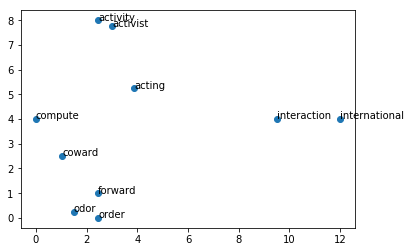

In [21]:
x = result[:,0]
y = result[:,1]
plt.plot(x,y,'o')
for xx,yy,word in zip(x,y,fastmap_wordlist):
    plt.annotate(word,(xx,yy))